# Creating Factories from Requests




## 1. Loadings Receipes

You will need mongodb runnning in the same directory to load the data. Make sure pymongo is at version 3.4 since it is the last version that support mongodb with OSI compatible license.

```bash
nix-shell -p "mongodb-3_4" --run "mongod --dbpath data"
```

In [21]:
import json
from pathlib import Path

d = {}

for f in Path("./d").glob("*.json"):
    d[f.stem] = json.load(open(f))

from pymongo import MongoClient

client = MongoClient()
client.drop_database("factorio")
db = client.factorio

del d["active_mods"]
for k, vs in d.items():
    for v in vs.values():
        db[k.replace("-", "_")].insert_one(dict(**v, **{"_id":v['name']}))


In [22]:
def is_fluid(name):
    for f in db["fluid"].find({"name": name}):
        return True
    return False

def is_item(name):
    for f in db["item"].find({"name": name}):
        return True
    return False

assert is_item("iron-ore")
assert not is_fluid("iron-ore")

assert not is_item("water")
assert is_fluid("water")

In [23]:
class HyperDiGraph:
    def __init__(self):
        self._edges = []
        self._nodes = set()

    def add_edge(self, A, B, data=None):
        self._edges.append((A, B, data))
        self._nodes.update(A)
        self._nodes.update(B)
    
    def in_edges(self, v):
        assert v in self._nodes
        return [(e[0], e[1]) for e in self._edges if v in e[1]]

    def in_edges_data(self, v):
        assert v in self._nodes
        return [e for e in self._edges if v in e[1]]

    def out_edges(self, v):
        assert v in self._nodes
        return [(e[0], e[1]) for e in self._edges if v in e[0]]

    def out_edges_data(self, v):
        assert v in self._nodes
        return [e for e in self._edges if v in e[0]]

    def edges(self):
        return [(e[0], e[1]) for e in self._edges]

    def edges_data(self):
        return [e for e in self._edges]

    def nodes(self):
        return [v for v in self._nodes]

    def edge_by_name(self, name):
        return next(d for (_, _, d) in self._edges if d["name"] == name)

In [24]:
recipes = HyperDiGraph()

for r in db.recipe.find({"hidden": False}):
    query = {f"crafting_categories.{r['category']}": {"$exists": True}, "name": {"$nin": ["kr-crash-site-assembling-machine-1-repaired", "kr-crash-site-assembling-machine-2-repaired"]}}
    for m in [m for m in db.assembling_machine.find(query)] + [m for m in db.furnace.find(query)]:

        if m["name"] in {"kr-advanced-assembling-machine", 'kr-advanced-chemical-plant', 'kr-advanced-furnace', "steel-furnace"}:
            continue

        A = {i["name"] for i in r["ingredients"]}
        B = {p["name"] for p in r["products"]}
        recipes.add_edge(A, B, {"recipe": r, "machine": m, "name": f"{r['name']}#{m['name']}"})

# display(next(iter(recipes.edges_data())))

In [25]:
# Semantic decomposition of items using recipes groups.

grouped = []
for r in db.recipe.find({"hidden": False}):
    if "main_product" in r:
        grouped.append(((r["group"]["name"], (r["subgroup"]["name"], r["main_product"]["name"]))))

from collections import defaultdict
gg = defaultdict(lambda: defaultdict(set))
for r in db.recipe.find({"hidden": False}):
    if "main_product" in r:
        gg[r["group"]["name"]][r["subgroup"]["name"]].add(r["main_product"]["name"])

grouped = sorted(grouped)

# [(k1, k2, len(v2)) for k1, v1 in gg.items() for k2, v2 in v1.items()]

## 2. Creating and solving the linear programming model

This uses external solvers. We encode our problem as a flow problem, where nodes are parametrized by recipes and machine usage. The flow constraints are on the ingredients/outputs. The model generates a annotated graph.

Todo: write problem description

In [26]:
import mip
import networkx as nx
import math
import arith

def compute_cost(data):
    return 1 # data["machine"]["energy_usage"]

def ingredient_coef(data, v):
    coef = data["machine"]["crafting_speed"] * sum(i["amount"] for i in data["recipe"]["ingredients"] if i["name"] == v) / data["recipe"]["energy"]
    assert coef > 0
    return coef

def product_coef(data, v):
    try:
        coef = data["machine"]["crafting_speed"] * sum(p["amount"]*p["probability"] for p in data["recipe"]["products"] if p["name"] == v) / data["recipe"]["energy"]
    except:
        coef = data["machine"]["crafting_speed"] * sum((p["amount_min"] + p["amount_max"])/2*p["probability"] for p in data["recipe"]["products"] if p["name"] == v) / data["recipe"]["energy"]
    assert coef > 0
    return coef

def optimize_model(graph, sources):
    model = mip.Model()
    model.verbose = 0

    flow_int = {data["name"]: model.add_var(f"flow_{data['name']}", lb=0, obj=compute_cost(data), var_type=mip.INTEGER) for a, b, data in graph.edges_data()}
    flow = {data["name"]: model.add_var(f"flow_{data['name']}", lb=0, obj=compute_cost(data)) for a, b, data in graph.edges_data()}
    
    for _, _, d in graph.edges_data():
        model.add_constr(flow[d["name"]] <= flow_int[d["name"]])
    
    diffs = {}    
    produced = {}
    used = {}
    
    considered = {}

    for v in graph.nodes():
        
        diff = mip.quicksum(flow[data["name"]] * ingredient_coef(data, v) for (_, _, data) in graph.out_edges_data(v)) - mip.quicksum(flow[data["name"]] * product_coef(data, v) for (_, _, data) in graph.in_edges_data(v))
        diffs[v] = diff 
        
        considered[v] = mip.quicksum(flow[data["name"]] * ingredient_coef(data, v) for (_, _, data) in graph.out_edges_data(v)) + mip.quicksum(flow[data["name"]] * product_coef(data, v) for (_, _, data) in graph.in_edges_data(v))
        
        for (_, _, data) in graph.in_edges_data(v):
            produced[v, data["name"]] = flow[data["name"]] * product_coef(data, v)
        
        for (_, _, data) in graph.out_edges_data(v):
            used[v, data["name"]] = flow[data["name"]] * ingredient_coef(data, v)
        
        # model.objective = model.objective - diff
        
        
        if v in sources:
            model.add_constr(diff <= sources[v])
        else:
            model.add_constr(diff <= 0)

    model.optimize(max_seconds=10)
    if model.status in [mip.OptimizationStatus.FEASIBLE, mip.OptimizationStatus.OPTIMAL]:
        return {
            "kind": "solution",
            "status": model.status,
            "diffs": {k: arith.float_to_frac(v.x) for k, v in diffs.items() if round(v.x, 3) != 0},
            "considered": {k for k, v in considered.items() if round(v.x, 3) != 0},
            "used": {k: arith.float_to_frac(v.x) for k, v in used.items() if round(v.x, 3) != 0},
            "produced": {k: arith.float_to_frac(v.x) for k, v in produced.items() if round(v.x, 3) != 0},
            "flow": {k: arith.float_to_frac(v.x) for k, v in flow.items() if v.x is not None and round(v.x, 3) > 0},
            "flow_int": {k: int(v.x) for k, v in flow_int.items() if v.x is not None and int(v.x) > 0},
        }
    else:
        return {
            "kind": "none",
            "status": model.status
        }

def build_detailed_graph(model):
    result = model

    assert result["kind"] == "solution"

    layout = nx.DiGraph()

    for u in result["considered"]:
        layout.add_node(u, kind="exchange")

    for u, w in result["flow_int"].items():
        layout.add_node(u, kind="sub-factory", amount=w)

    for (u, v), w in result["used"].items():
        layout.add_edge(v, u, flow=w)

    for (u, v), w in result["produced"].items():
        layout.add_edge(u, v, flow=w)

    for u, info in layout.nodes(data=True):
        if info["kind"] == "exchange":
            size = max(sum(math.ceil(f/15) for u, v, f in layout.out_edges(u, data="flow")),
                       sum(math.ceil(f/15) for u, v, f in layout.in_edges(u, data="flow"))) * 5
            layout.nodes[u]["size"] = size
            layout.nodes[u]["width"] = size
            layout.nodes[u]["height"] = size
            layout.nodes[u]["in__flow"] = sum(f for u, v, f in layout.in_edges(u, data="flow"))
            layout.nodes[u]["out_flow"] = sum(f for u, v, f in layout.out_edges(u, data="flow"))
        elif info["kind"] == "sub-factory":
            size = math.ceil(math.sqrt(info["amount"])) * 5
            layout.nodes[u]["size"] = size
            layout.nodes[u]["width"] = size
            layout.nodes[u]["height"] = size
        else:
            assert False
    
    return layout

In [31]:
### Example utilization
import layout
from importlib import reload
reload(layout)

# What is available in the factory. The model will say to you for each of those items what flow is needed.
source = {
    "iron-ore": float("+inf"),
    "crude-oil": float("+inf"),
    "copper-ore": float("+inf"),
    "stone": float("+inf"),
    "coal": float("+inf"),
    "water": float("+inf"),
    "wood": float("+inf"),
    "brick": float("+inf"),
    "steel-plate": float("+inf"),
    "imersite-powder": float("+inf"),
    "mineral-water": float("+inf"),
    "raw-rare-metals": float("+inf"),
    "plastic": float("+inf"),
}

# What should be produce (item per second)
target = {
    k: 1 for k in {'advanced-tech-card',
 'automation-science-pack',
 'basic-tech-card',
 'biters-research-data',
 'chemical-science-pack',
 'logistic-science-pack',
 'matter-research-data',
 'matter-tech-card',
 'military-science-pack',
 'production-science-pack',
 'singularity-tech-card',
 'utility-science-pack'}
}

# Build the model and solve it.
model = optimize_model(recipes, dict(**source, **{k: -v for k, v in target.items()}))
result = layout.get_layout(build_detailed_graph(model))



Starting solution of the Linear programming relaxation problem using Primal Simplex

Coin0506I Presolve 392 (-1259) rows, 576 (-1846) columns and 1394 (-5611) elements
Clp1000I sum of infeasibilities 0.00227862 - average 5.8128e-06, 156 fixed columns
Coin0506I Presolve 285 (-107) rows, 400 (-176) columns and 940 (-454) elements
Clp0006I 0  Obj 8645.0425 Primal inf 0.00181581 (43) Dual inf 3.522567e+10 (400)
Clp0029I End of values pass after 400 iterations
Clp0014I Perturbing problem by 0.001% of 4.7179041 - largest nonzero change 0 ( 0%) - largest zero change 2.982246e-05
Clp0000I Optimal - objective value 4323.3838
Clp0000I Optimal - objective value 4323.3838
Coin0511I After Postsolve, objective 4323.3838, infeasibilities - dual 0 (0), primal 0 (0)
Clp0006I 0  Obj 4323.3838 Dual inf 12.83319 (8)
Clp0014I Perturbing problem by 0.001% of 4.0714442 - largest nonzero change 1.9274758e-05 ( 0.0019274758%) - largest zero change 2.982246e-05
Clp0000I Optimal - objective value 4318.4123
Clp00

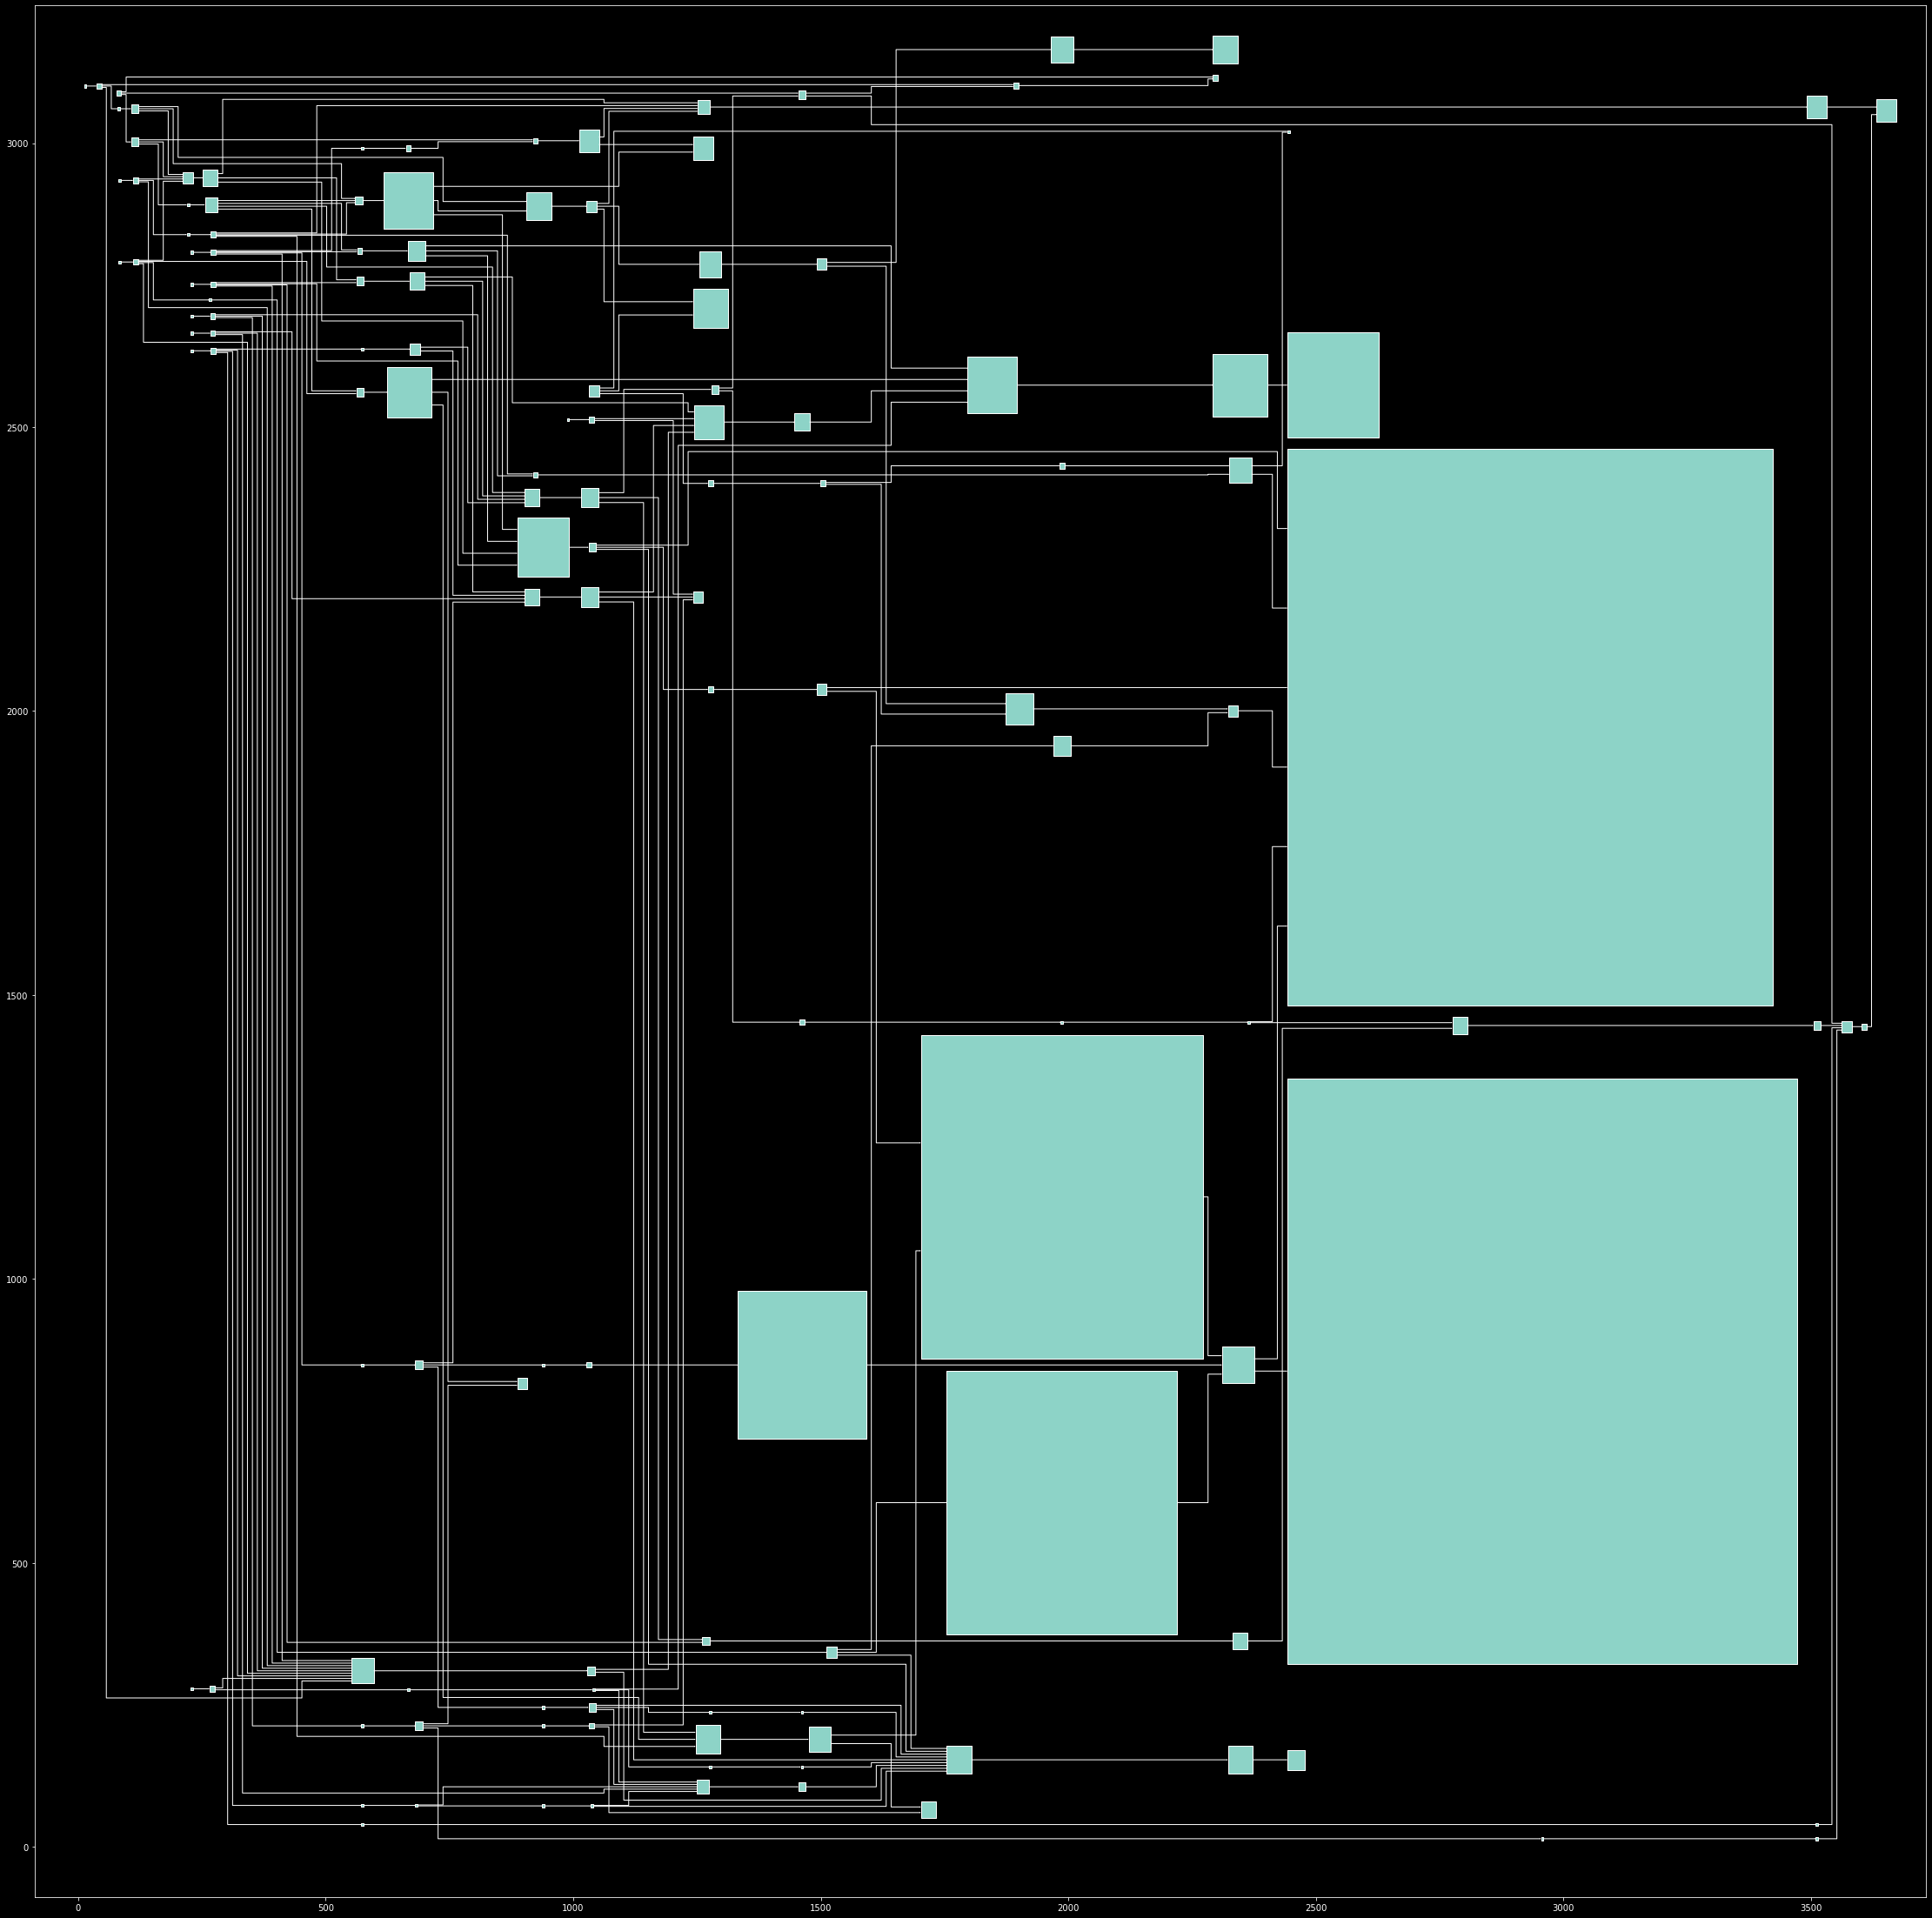

In [38]:
import layout
from importlib import reload
reload(layout)
layout.plot_layout(result)

## Bin packing

Inputs:
* $v[j]$ output flow required
* $u[i]$ input flow required

Variables:
* $x[i, j]$ real between 0 and 1, indicate the flow from $i$ to j$
* $y[i, j]$ boolean indicate if the edge from $i$ to $j$

Minimize $\displaystyle \sum_{i, j} y[i, j]$
Subject:
* $\displaystyle \forall i j, x[i, j] \leq y[i, j]$
* $\displaystyle \forall i, \sum_j x[i, j] = u_i$
* $\displaystyle \forall j, \sum_i x[i, j] = v_i$

In [39]:
import functools

def _optimize_packing(inputs, outputs):
    m = mip.Model()
    m.verbose = 0
    
    assert sum(inputs) == sum(outputs)
    
    x = {(i, j): m.add_var(f"flow_{i, j}", lb=0, ub=1) for i, _ in enumerate(inputs) for j, _ in enumerate(outputs)}
    y = {(i, j): m.add_var(f"flow_bool_{i, j}", lb=0, ub=1,var_type=mip.BINARY, obj=10000) for i, _ in enumerate(inputs) for j, _ in enumerate(outputs)}
    nx.draw(result)
    for i, _ in enumerate(inputs):
        for j, _ in enumerate(outputs):
            m.add_constr(x[i, j] <= y[i, j]*1)
    
    for i, v in enumerate(inputs):
        m.add_constr(mip.quicksum(x[i, j] for j, _ in enumerate(outputs)) == v)
    
    for j, v in enumerate(outputs):
        m.add_constr(mip.quicksum(x[i, j] for i, _ in enumerate(inputs)) == v)
        
    m.optimize(max_seconds=1)
    
    
    x = {k: arith.float_to_frac(v.x) for k, v in x.items() if arith.float_to_frac(v.x) > 0}
    y = {k: arith.float_to_frac(v.x) for k, v in y.items()}
    
    return {"x": x, "y": y}



def optimize_packing(inputs, outputs):
    return _optimize_packing(tuple(inputs), tuple(outputs))



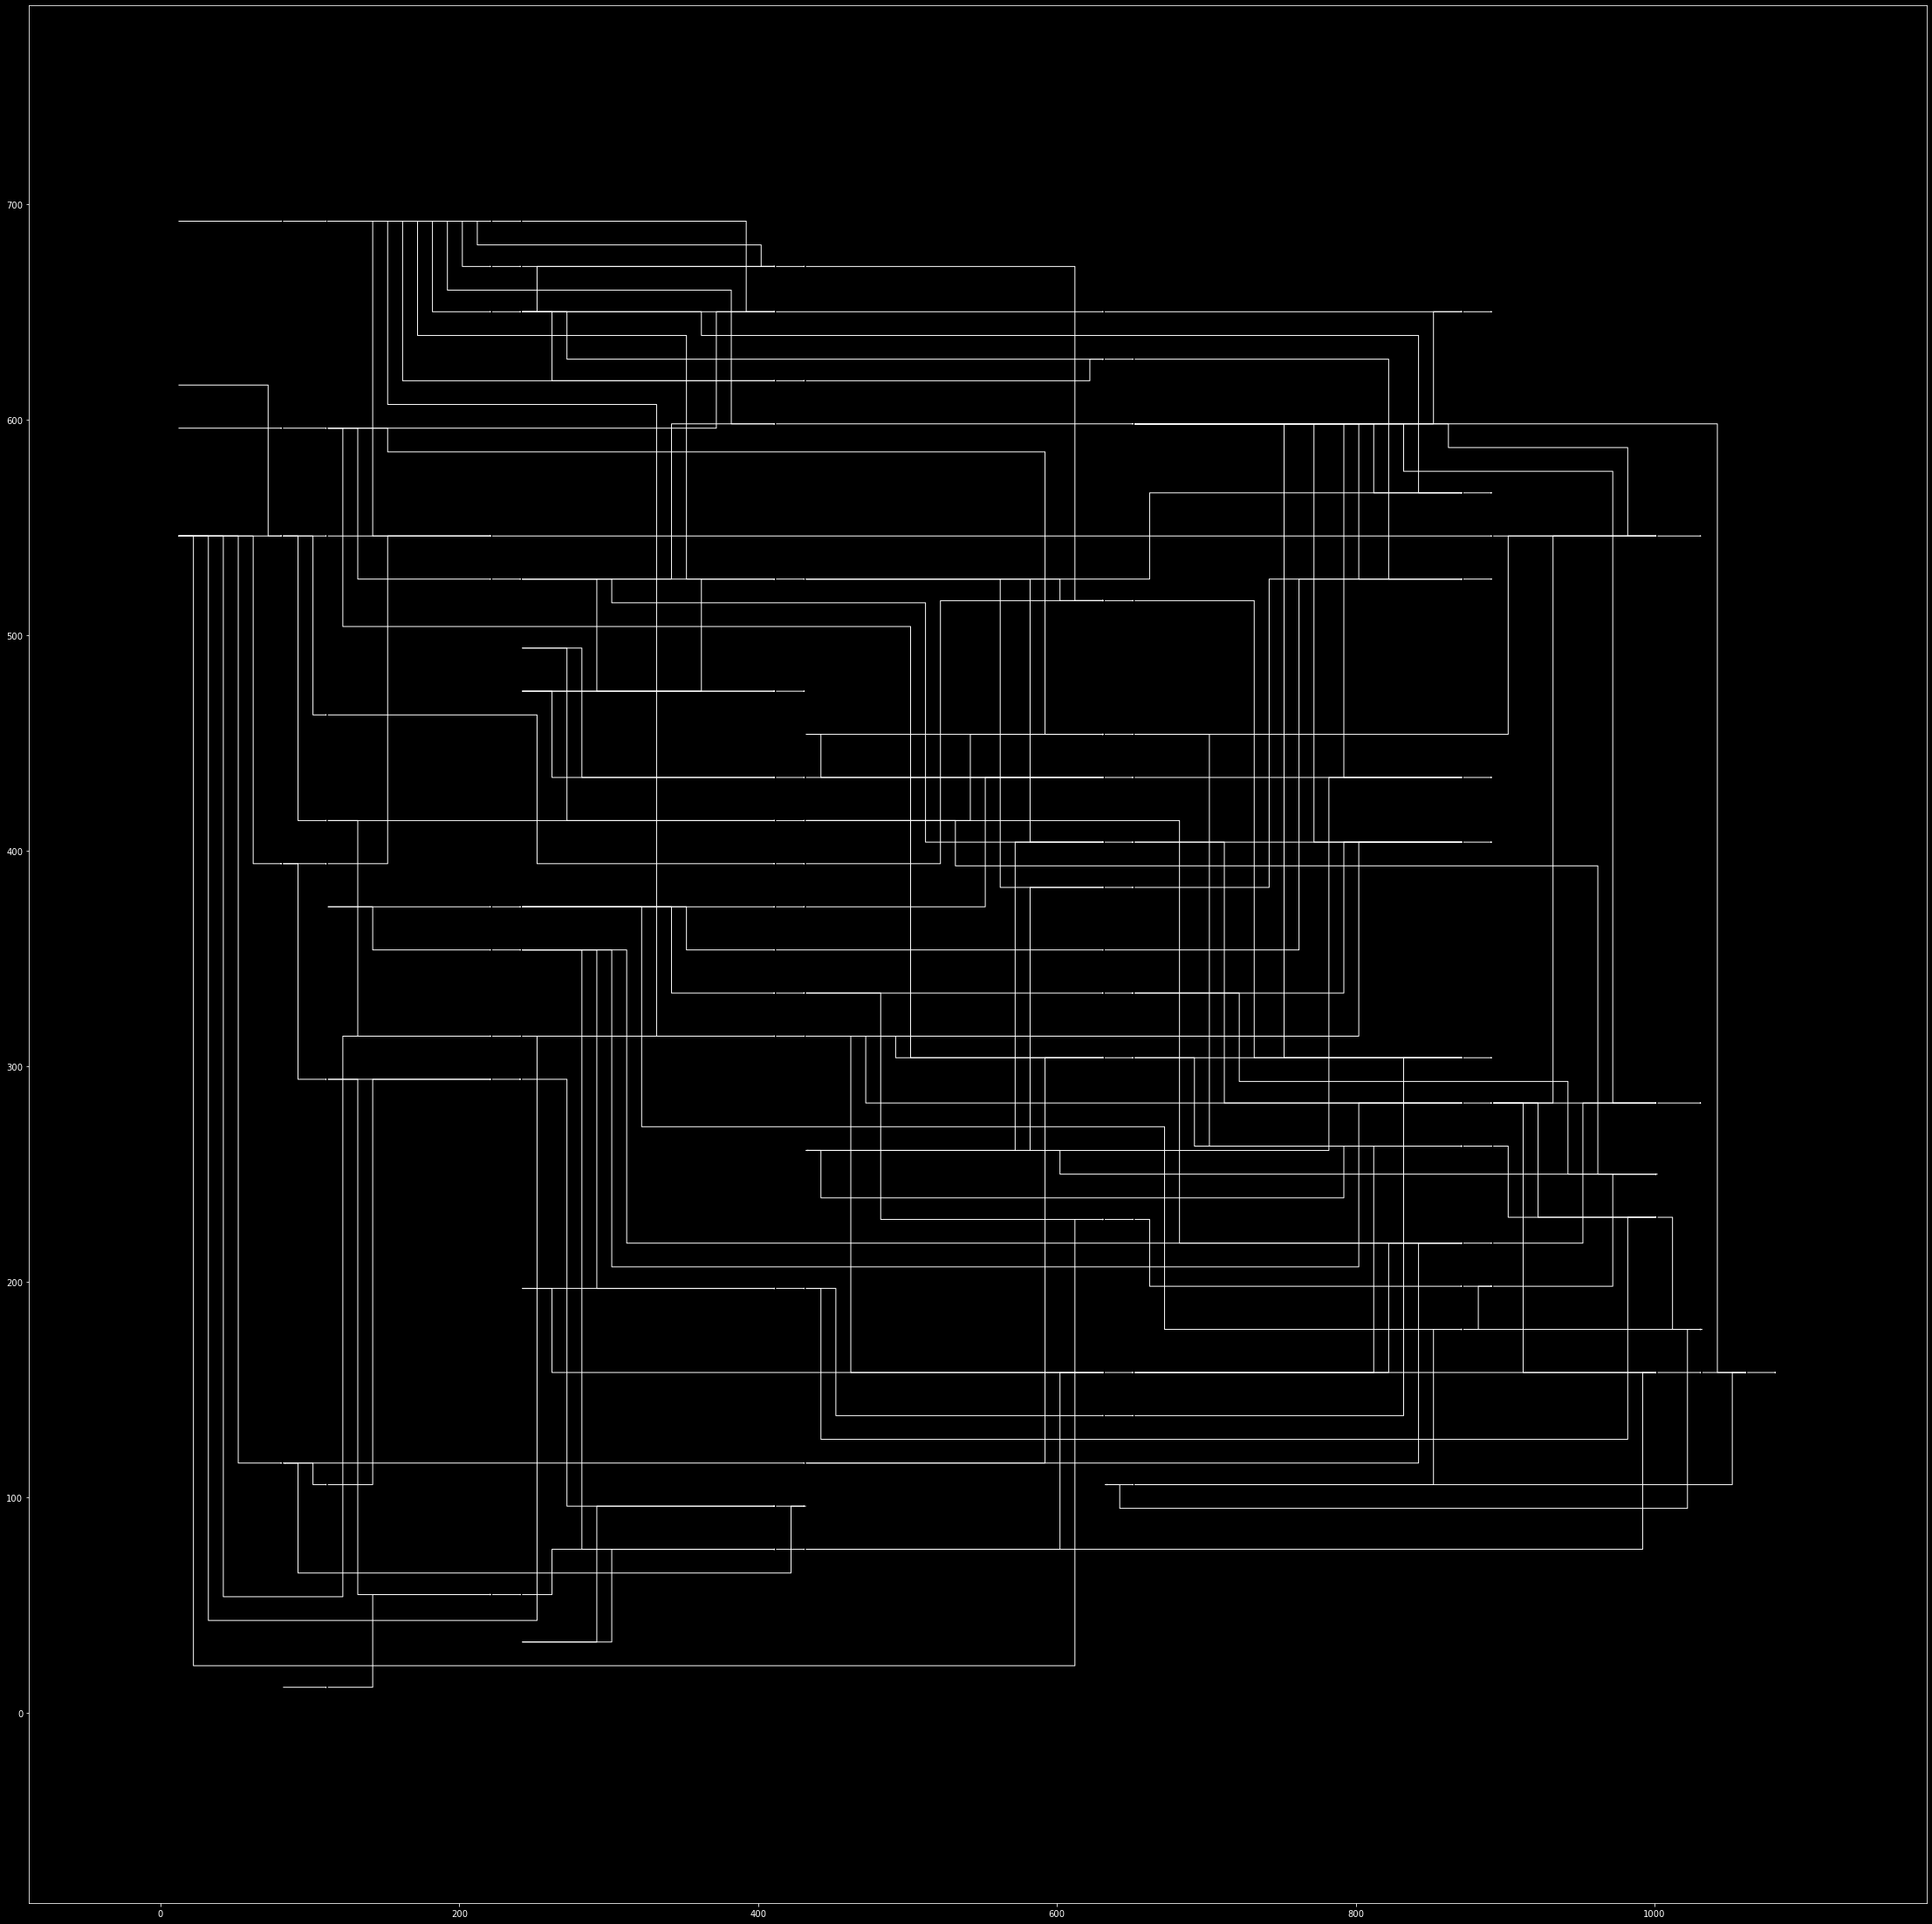

In [40]:
# We first generate the initial layout graph.

from itertools import count

used = defaultdict(dict)
for (k1, k2), v in model["used"].items():
    used[k2][k1] = v
dict(used)

produced = defaultdict(dict)
for (k1, k2), v in model["produced"].items():
    produced[k2][k1] = v
dict(produced)

def split_fluid_items(l):

    fluids = {}
    items = {}
    for k, v in l.items():
        assert (is_fluid(k) ^ is_item(k))

        if is_fluid(k):
            fluids[k] = v

        if is_item(k):
            items[k] = v

    return {"fluid": sum(fluids.values()), "items": sum(items.values())}

assert model["kind"] == "solution"

layout = nx.DiGraph()

for u in model["considered"]:
    layout.add_node(u, kind="exchange", item=u)

for u, w in model["flow_int"].items():
    recipe, machine = u.split("#")
    f = model["flow"][u]
    layout.add_node(u, kind="sub-factory", amount=w, flow=f, recipe=recipe, machine=machine)

for (u, v), w in model["used"].items():
    layout.add_edge(u, v, flow=w)

for (u, v), w in model["produced"].items():
    layout.add_edge(v, u, flow=w)


layout1 = layout
def divmod(p, q):
    return p//q, p%q


request length : 108531


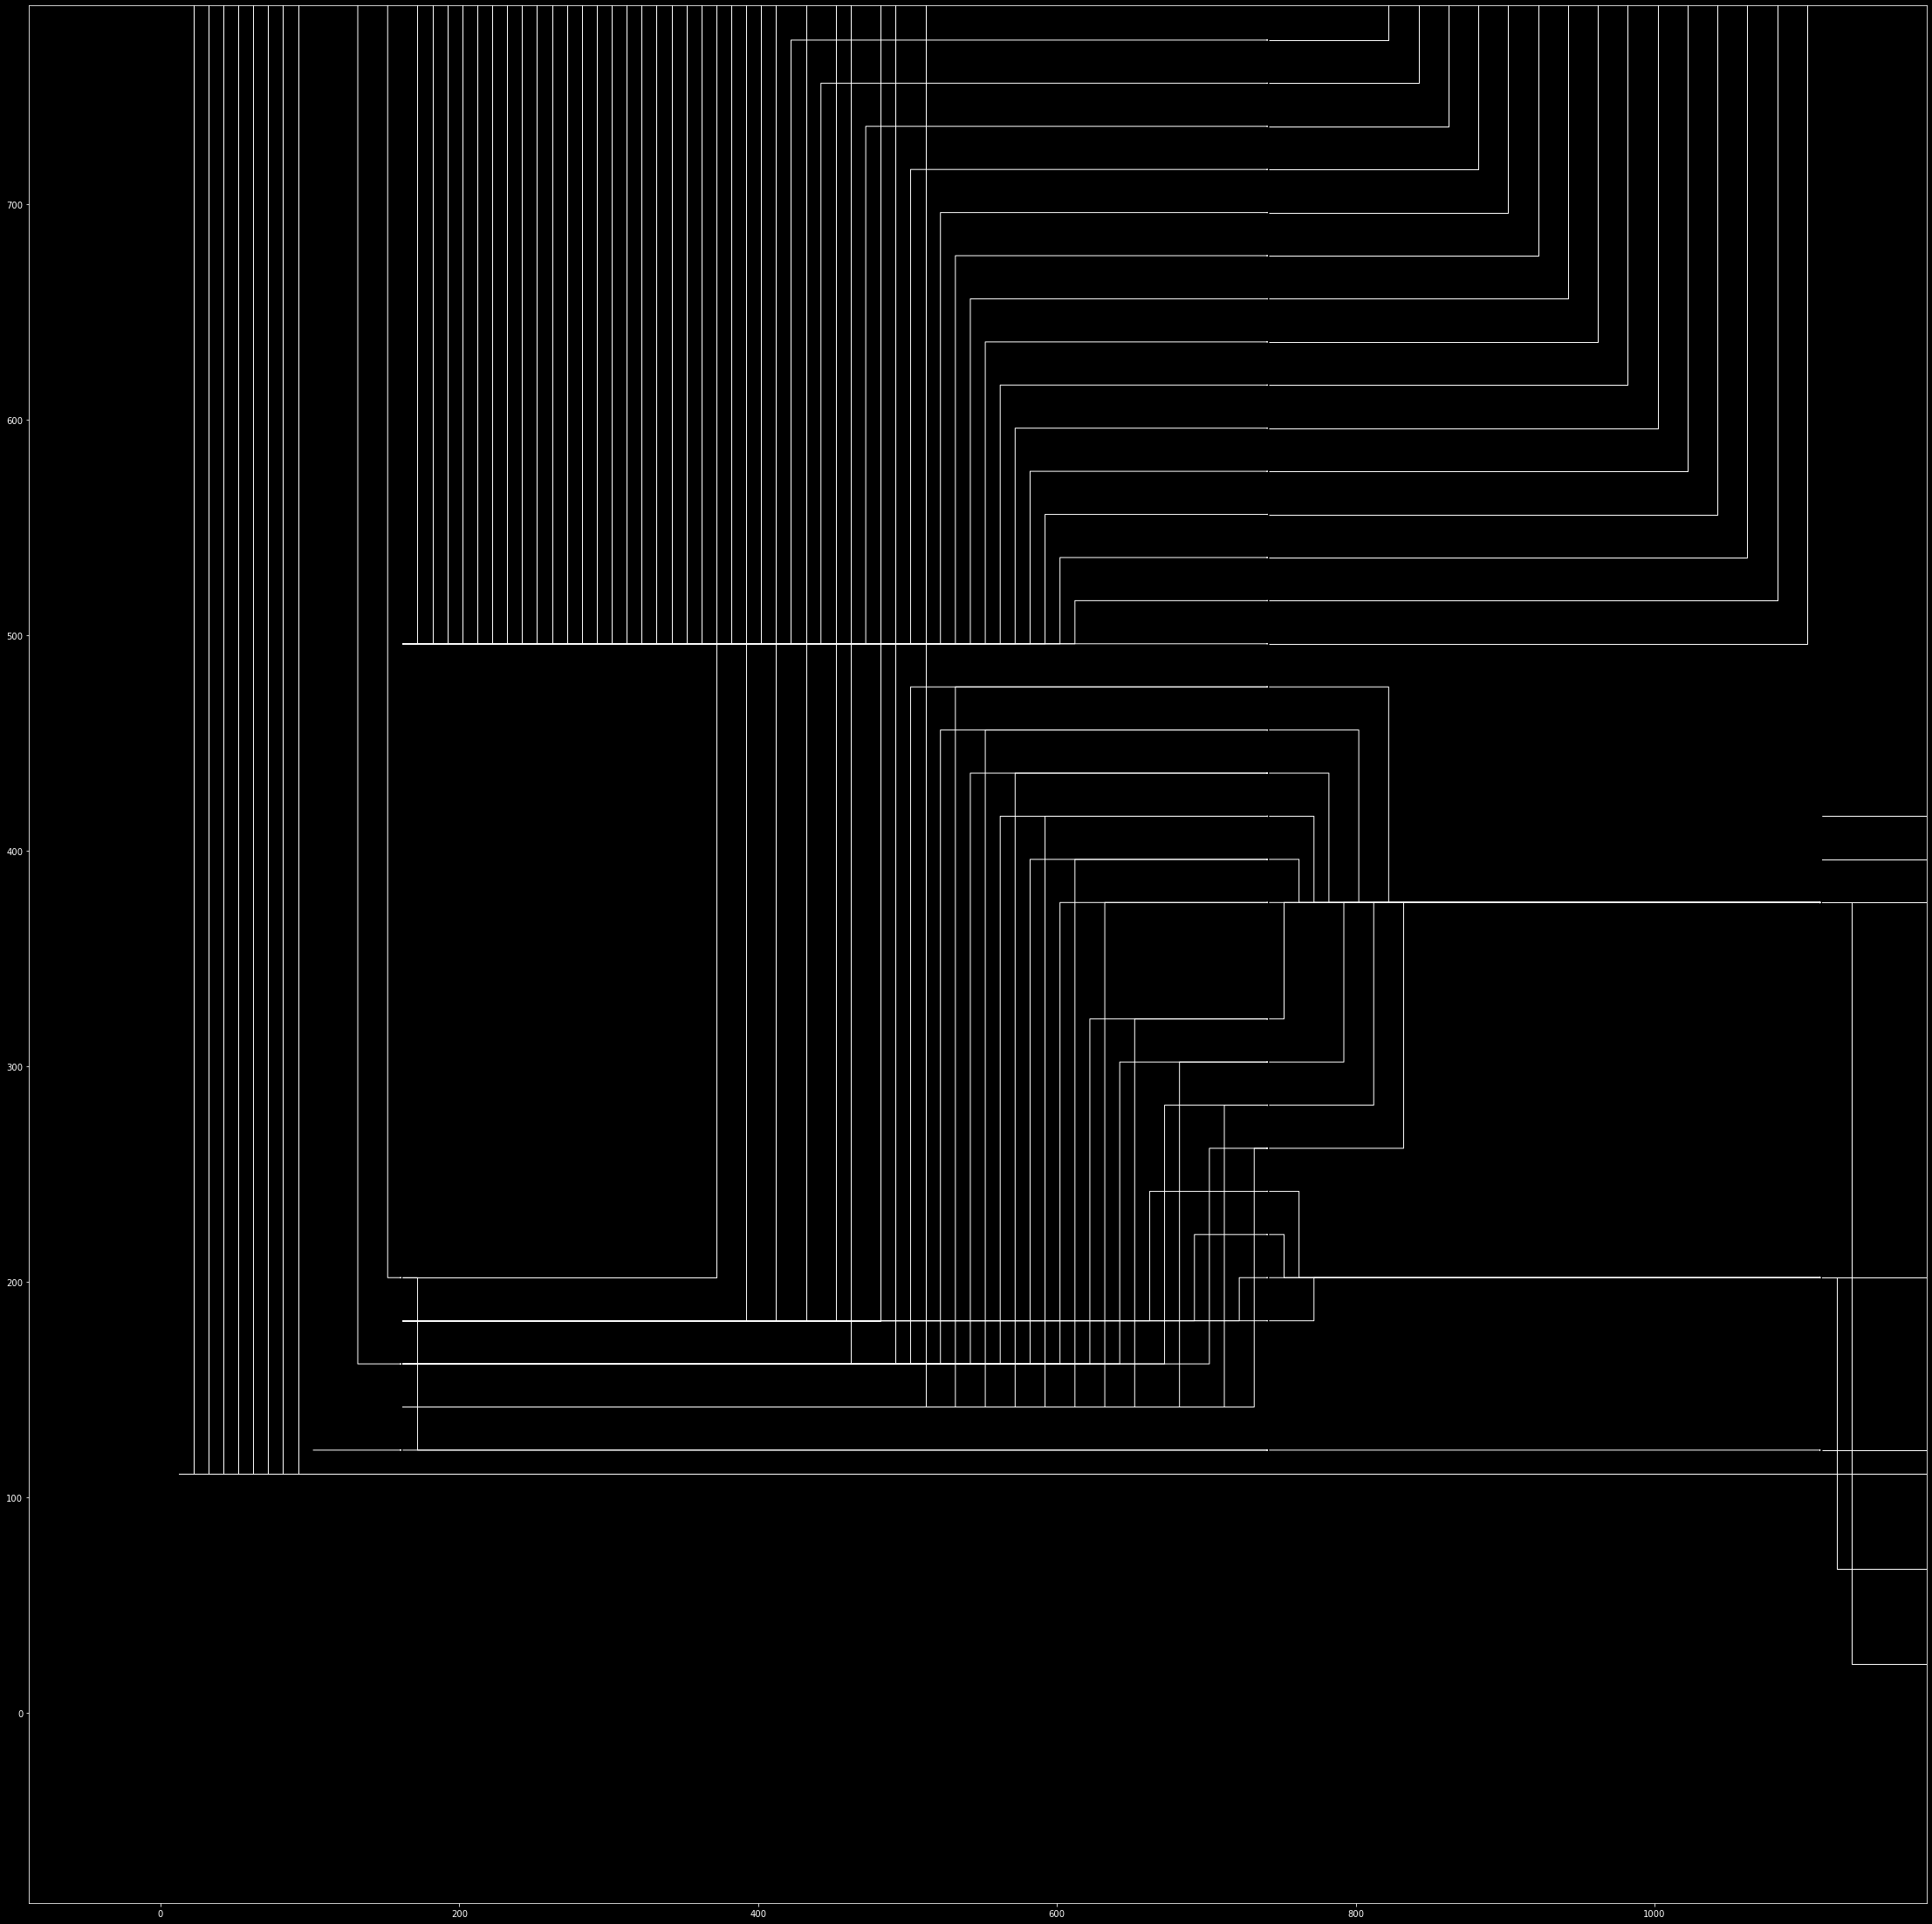

In [49]:
# For each sub-factory nodes, if the input or output is above a threshold, we split the node into multiple sub-factories nodes.
changed_layout = layout1.copy()
for u, info in layout1.nodes(data=True):
    if info["kind"] != "sub-factory":
        continue

    in_flow = {u: data["flow"] for u, _, data in layout1.in_edges(u, data=True)}
    out_flow = {u: data["flow"] for _, u, data in layout1.out_edges(u, data=True)}

    total_in = split_fluid_items(in_flow)
    total_out = split_fluid_items(out_flow)

    total = max(total_in["items"], total_out["items"])
    if total > 15:
        changed_layout.remove_node(u)
        per_machine = (total/info["flow"])
        max_machine_per_belt = 15//per_machine
        c = count()
        left = total

        while left > per_machine * max_machine_per_belt:
            i = next(c)
            left -= per_machine * max_machine_per_belt
            newinfo = info.copy()
            newinfo["amount"] = max_machine_per_belt
            newinfo["flow"] = max_machine_per_belt
            newinfo["id"] = i

            n = f"{u}#{i}"
            changed_layout.add_node(n, **newinfo)

            new_in_flow = {k: v/info["flow"]*newinfo["flow"] for k, v in in_flow.items()}
            new_out_flow = {k: v/info["flow"]*newinfo["flow"] for k, v in out_flow.items()}
            
            for k, v in new_in_flow.items():
                changed_layout.add_edge(k, n, flow=v)
            
            for k, v in new_out_flow.items():
                changed_layout.add_edge(n, k, flow=v)
            
        if left > 0:
            i = next(c)
            newinfo = info.copy()
            newinfo["amount"] = math.ceil(left/per_machine)
            newinfo["flow"] = left/per_machine
            newinfo["id"] = i

            n = f"{u}#{i}"
            changed_layout.add_node(n, **newinfo)

            new_in_flow = {k: v/info["flow"]*newinfo["flow"] for k, v in in_flow.items()}
            new_out_flow = {k: v/info["flow"]*newinfo["flow"] for k, v in out_flow.items()}

            for k, v in new_in_flow.items():
                changed_layout.add_edge(k, n, flow=v)

            for k, v in new_out_flow.items():
                changed_layout.add_edge(n, k, flow=v)

layout2 = changed_layout


import layout
reload(layout)
layout.plot_layout(layout2)


In [12]:
# add sources and sinks for each items that is provided or produced. Their position can be decided in the future using the interactive feature of elk.

changed_layout = layout2.copy()
for u, info in layout2.nodes(data=True):
    if info["kind"] != "exchange":
        continue
    
    A = [f for _, _, f in changed_layout.in_edges(u, data="flow")]
    B = [f for _, _, f in changed_layout.out_edges(u, data="flow")]
    
    if sum(A) > sum(B):
        n = f"{u}#target"
        changed_layout.add_node(n, kind="sink")
        changed_layout.add_edge(u, n, flow=sum(A) - sum(B))
    elif sum(A) < sum(B):
        n = f"{u}#source"
        changed_layout.add_node(n, kind="source")
        changed_layout.add_edge(n, u, flow=sum(B) - sum(A))
    else:
        pass


layout3 = changed_layout

In [13]:
# The for each exchange, we apply the optimization algorithm to choose a repartition between producers and consumers. This calls an linear program at each iteration.

from importlib import reload
import fractionnal_spliter
import blueprint
reload(blueprint)
reload(fractionnal_spliter)


changed_layout = layout3.copy()
for u, info in layout3.nodes(data=True):
    if info["kind"] != "exchange":
        continue
    if not is_item(u):
        continue

    c = count()

    in_edges = {v: f for v, _, f in changed_layout.in_edges(u, data="flow")}
    out_edges = {v: f for _, v, f in changed_layout.out_edges(u, data="flow")}
    total = sum(in_edges.values())
    idxA, A = zip(*[(v, a/total) for v, a in in_edges.items()])
    idxB, B = zip(*[(v, b/total) for v, b in out_edges.items()])

    x = optimize_packing(A, B)["x"]

    per_input = defaultdict(dict)
    for (k1, k2), v in x.items():
        if not (v > 0):
            continue
        per_input[idxA[k1]][idxB[k2]] = v

    per_input = dict(per_input)

    # remove the node
    changed_layout.remove_node(u)

    # add the nodes that do the splitting

    for k1, v1 in per_input.items():
        idxBb, Bb = zip(*{k2: v2/sum(v1.values()) for k2, v2 in v1.items()}.items())

        fractionnal_spliter.build_graph(Bb, f"{k1}.{info['item']}", [f"{out}.{info['item']}" for out in idxBb], graph=changed_layout, c=c)

    # break

changed_layout.nodes(data=True)


Starting solution of the Linear programming relaxation problem using Primal Simplex

Coin0506I Presolve 0 (-3) rows, 0 (-2) columns and 0 (-4) elements
Clp0000I Optimal - objective value 10000
Coin0511I After Postsolve, objective 10000, infeasibilities - dual 0 (0), primal 0 (0)
Clp0032I Optimal objective 10000 - 0 iterations time 0.002, Presolve 0.00, Idiot 0.00

Starting MIP optimization
Cgl0004I processed model has 0 rows, 0 columns (0 integer (0 of which binary)) and 0 elements
Cgl0015I Clique Strengthening extended 0 cliques, 0 were dominated
Cbc3007W No integer variables - nothing to do
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Starting solution of the Linear programming relaxation problem using Primal Simplex

Coin0506I Presolve 0 (-9) rows, 0 (-8) columns and 0 (-16) elements
Clp0000I Optimal - objective value 10000
Coin0511I After Postsolve, objective 10000, infeasibilities - dual 0 (0), primal 0 (0)
Clp0032I Optimal objective 10000 - 0 iterations

: 

: 

In [33]:
len(str(changed_layout.nodes(data=True)))

37157

In [16]:
db.recipe.find_one({"name":"electronic-components"})


{'_id': 'electronic-components',
 'name': 'electronic-components',
 'localised_name': ['item-name.electronic-components'],
 'category': 'crafting',
 'order': 'e02[ei-electronic-components]',
 'group': {'name': 'intermediate-products', 'type': 'item-group'},
 'subgroup': {'name': 'intermediate-product', 'type': 'item-subgroup'},
 'enabled': False,
 'hidden': False,
 'hidden_from_player_crafting': False,
 'emissions_multiplier': 1,
 'energy': 4,
 'ingredients': [{'type': 'item', 'name': 'glass', 'amount': 2},
  {'type': 'item', 'name': 'silicon', 'amount': 2},
  {'type': 'item', 'name': 'plastic-bar', 'amount': 2}],
 'products': [{'type': 'item',
   'name': 'electronic-components',
   'probability': 1,
   'amount': 4}],
 'main_product': {'type': 'item',
  'name': 'electronic-components',
  'probability': 1,
  'amount': 4}}

In [17]:
# We then prepare the graph for the layout algorithm to do it's job.

for u, info in layout.nodes(data=True):
    if info["kind"] == "exchange":
        # TODO
        # layout.nodes[u]["size"] = size
        # layout.nodes[u]["width"] = size
        # layout.nodes[u]["height"] = size
    elif info["kind"] == "sub-factory":
        # TODO
        # size = math.ceil(math.sqrt(w)) * 5
        # layout.nodes[u]["size"] = size
        # layout.nodes[u]["width"] = size
        # layout.nodes[u]["height"] = size
    else:
        assert False

IndentationError: expected an indented block after 'if' statement on line 4 (3972496595.py, line 9)

# Sub-factory with assembly machine 3



In [ ]:
import blueprint
book = blueprint.loads("0eNrFWtuOozgQ/Reewwgbc3He9r7/sIoiQjxpq7kJTGtbo/73NUknpCdcqiqglfICiQ+nyuVjcyo/nEPWqqrWhdkfyvLV2f7o7zTO9p+7y+47nZbF5XajT0WSdffMe6WcraONyp2NUyR5d2XqpGiqsjbuQWXG+dg4ujiqf50t+9jMDm6qTBuj6rth/GO3cVRhtNHqQuB88b4v2vxgf7ll/WhT1slJuSYpXi1mVTZ2UFl0T7NAsf8t2DjvdkD8LbD4R12r9PI976j9BMtvsFWbVwNw4QUsgoD5PZi2YT+CRVduHdwAgJgDYFcAOQwQgAHiYYDwBtBVgk2xcdMyP+gisVkfwPNGs21jsRCmLrP9Qb0kb9qOt4O+68zO/EiNvenatPZOP9fnX7h/d5WSlm1XpOyu1HZDIUTEEDhbM4S/MCHEY+tsfEIf2Q9VqHxcg4+Q/ArJfwLcfIZuhx/VObl1e/7OrbKkKM5gZWuq1uytopS1fbL9aaa+dwLxuKI96kTxNSfqT8xEMUaNwV8zhj9QMXBCtfmQamM+AZmDkAUcmeM4B5Al4t8w110iIYSMuJIR65IhC6tYs9Z/R9V6TI0hWDOG31AxSMKqCkCHIY+ALEDIjLBeYZw5ARnGGaFePo6zICDDOAdwZIHjDJKi4Ia5qhTxCEImvJIJ1yVD1pRwTU35FaMpXFJjiNaM4RdMDD5FvWDvdYyAHIKQKeoF4+wTkGGcKeoF4xwQkGGcQ4IuwpAjOHKAQ44JnGF5lgTOIGSBWIMhDplBJD+6YS4o+bvNxb/a3nllGydLbFydtVXYQfb6zarb5VkxE5HkURDaj4h7j8vrwqLZbUnTqPyQ6eLk5kn6ogvl+kjTbdSxQ1hvI6ZSPGNr8TkAOQMwZ6xJD2yszZalvLfYZsvyq+HmmtI91Xa/Ok4Bz1pvcxz7cB84iklDDBw8zE2KCcDecPAgYyq+sQO8x3v4dJ7JzSMzAjIbDptxfP0M2F/T3os9zqWvri4aVc/kFYYspmVpgrkYyUK/inJ11G3uqswyqHXqVmU2td4/GRdKn14OZXs+X7JwN22lwJ7RZyUceEawm3ZI4AsCtPsxxFKLccgSXCdy4sXlOTdBehOcp7ffXB+P5+mb338Zff/9H9tdIzseA++50/0yGaD6ZbM78bMtLvlsi0vCW1zDLT/pI/b/CJyPETZI80DGX6drsVftCPOqDdmtJRvbre/O4klryjw5n8ObVKsiVW5lRYjaR5rVGR91vmGQdw4JaZdl5Uk3xu419Cg5IUpv4S5NH6u3cJfmJkPAmYE7BVLgkEMCZ1g2IgJnb+HTwU2PgNmAOwUyRCFjTgcRKhuIXkPP2UP2GnBi/ZmSxcSaobxdn8raW5a1h2ItINoL6cPm2g5P6ne69iK6Kr0m+It1VSSkwZu+qFynNsv0KCn6BOrW85iQPxiyJKgIaGYQ3YReRfyFuwk9Z75wN6HnzJHdBKSG+MtqiI/qCAkqa74sa45iDfkHioR0WlvTSd8TwueD5AnSZ23ss9UTRCLCmgkW7rL0yGLhLkufQoHssiDrOli2rgNMXQtGZS2WZS1QrO+MlDzJMjdLBk2DL93ZIRwf63F+6coOIQpC5YI6jyKgzlS47EyF4zM17QpelAXkCg4ajO75z/IbJ7FZelP7awNvAu/jP/ann2M=")

book = {b["blueprint"]["label"]: blueprint.clean(b["blueprint"]["entities"]) for b in book["blueprint_book"]["blueprints"]}


book

In [18]:
import fractionnal_spliter
import blueprint
from fractions import Fraction as F

blueprint.dumps(blueprint.bp_from_entities(fractionnal_spliter.entitites_from_frac(F(4687, 33102))))

'0eJzUvd/OLMd15PsqA12Pja78n3N3nuNgYEg2x0NAJgV6yziG4Xc/25RnvtUwVV0RmRGouiMpiqsrKzNjr4jVv/633/3hj3/+4U+//PjTt9/9j//2b7/78e9//umfv//V//s///t/+90PP3378duPP/z69//2l7/717/76c//9Icffvn+j47v/8ZPv/+nH77/5e/+4//17fc/ffubv//5n/7w40+///bzL7/7/j//6ed//v4f+PmnX//T/99//H/+9vX9H//r9796/e3r37//5T/8+MsPf/+f/0r677/+h7798vMf/+4PP/zv3//Ljz//8uv/83/9+MdvP/zynx/jn3/8x59+/8df//m3f/3Tr9V//PbDP/0ufJp/+OHXz/PLn3/9L//Nn/74+59++v6R//3X//6ff33S//jwP/70Dz/8+qH+/X/++/f/7b8+YSKe8PV/n7D85QmpJ/qXH3/59ufv/yx8gL/8W3/z/+CPkcN/5dsvv//pn//08y/f/uYPP/zx24d3VH7jHf1mhbK0FcYDtsKBrWE63ecfN9uFChmvAO6Dglco7Cpd3mmVfYb6XyuU36zQ4pn70x9//PZ9v314A+Vv67VP39lPf3l9BvsG+tUKk63Qrr6B44W/gv4br+D73//luji5CL7/Oz//+duf/vzt775r4M+/fP8c//Ev//GH//Xtd7/92cCLIJ89fvvtEuBNUIgS4FWQTu/q3y4B3gWFKIFVqPI7ucnv5CG/kzteAbyTJ16hse/h8r0J3sztTFe23MwVfwbwZq74M1y/mQcujujV2onPDx7ojr8E9GqdRAnwSE/8D0FHPNN//v6H41/+8Zfvf1z+hyu76T9V6P/8ifwv8vpX1BQ82J34wwR4sgehpgM/FbY/r4CXQsf/QJhe7Ha8vMIJvBq+rud5dZ8k8Gqo+J9XUrwawEM13w/Vjz/91TOVwNuhEQ8CKv44ex1/5Y3TN8P1EuDN0ImFAkV/Ek8BHvCJP0

[3,
 7,
 15,
 1,
 292,
 1,
 1,
 1,
 2,
 1,
 3,
 1,
 14,
 3,
 3,
 2,
 1,
 3,
 3,
 7,
 2,
 1,
 1,
 3,
 2,
 42,
 2]

In [17]:
a = iter(reversed([0, 7, 15, 1, 292]))

x = F(next(a))
for y in a:
    x = y + 1/x

x


Fraction(4687, 33102)